In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal.windows import tukey

from tqdm.notebook import tqdm

In [2]:
rf = np.load("intermediate_results/us_linear_inhomog.npy")
# (ntransmissions, ntimesamples, nreceivers, 1)

In [3]:
n_include = 64

# Remove receivers outside +/- n_include.
rf_select = np.zeros((rf.shape[0], rf.shape[1], n_include * 2 + 1))
for i in range(rf.shape[0]):
    if i < n_include:
        # zero pad
        rf_select[i, :, n_include - i :] = rf[i, :, 0 : i + n_include + 1, 0]
    elif i > rf.shape[0] - n_include - 1:
        extra = n_include - (rf.shape[0] - i - 1)
        rf_select[i, :, :-extra] = rf[i, :, i - n_include :, 0]
    else:
        rf_select[i, :, :] = rf[i, :, i - n_include : i + n_include + 1, 0]

In [4]:
detx = np.linspace(-0.02 * np.sqrt(3), 0.02 * np.sqrt(3), rf.shape[2])
dety = 0.02 * np.ones_like(detx)
c = 1540
fs = 4e7

In [5]:
chirp_centre = int(2e-6 * fs)
chirp_width = int(4e-7 * fs)

window = np.zeros(rf.shape[1])
window[: chirp_centre * 2] = 0
window[chirp_centre * 2 :] = tukey(rf.shape[1] - 2 * chirp_centre, 0.2)
y = rf_select * window[None, :, None]
# y = y[:, chirp_centre:]

In [6]:
y *= np.exp(np.arange(y.shape[1]) / 4000)[None, :, None]

In [7]:
# a, b = butter(3, [1e6, 4e6], btype="bandpass", fs=4e7)
# filtered = filtfilt(a, b, y, axis=1, padlen=0)

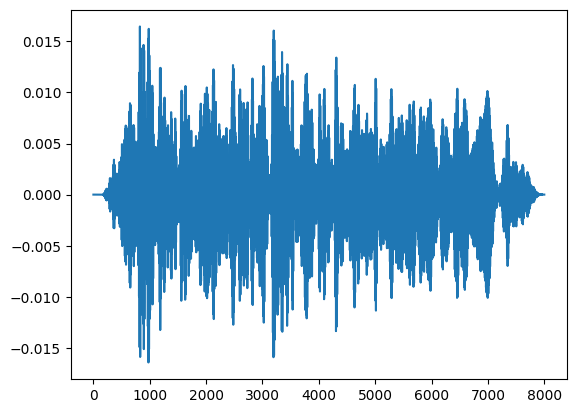

In [8]:
plt.plot(y[0, :, n_include].real)
# plt.plot(filtered[0, :, n_include].real)
plt.show()

In [9]:
y = hilbert(y, axis=1)

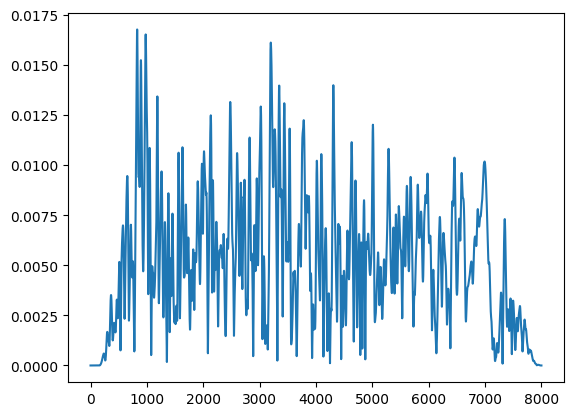

In [10]:
plt.plot(np.abs(y[0, :, n_include]))
plt.show()

In [11]:
# Delay and sum:
nx = 400
lx = 0.04

# Center of pixels
xs = np.linspace(-lx / 2, lx / 2, nx)

X, Y = np.meshgrid(xs, xs)

image = np.zeros((nx, nx), dtype=np.complex128)

# Transmission loop
for i in tqdm(range(rf.shape[2])):
    # Reception loop
    distance_0 = np.sqrt((X - detx[i]) ** 2 + (Y - dety[i]) ** 2)
    partial_image = np.zeros((nx, nx), dtype=np.complex128)
    count = 0
    for k in range(max(0, i - n_include), min(i + n_include + 1, rf.shape[2])):
        j = k - i + n_include

        distance_1 = np.sqrt((X - detx[k]) ** 2 + (Y - dety[k]) ** 2)
        index = ((distance_0 + distance_1) / (c / fs)).astype(int) + chirp_centre
        index[index >= y.shape[1]] = 0
        partial_image += y[i, index, j]
        count += 1
    image += partial_image / count  # np.abs(partial_image) ** 2

  0%|          | 0/256 [00:00<?, ?it/s]

In [12]:
us_image = np.abs(image) * np.exp(np.arange(400) / 200)[::-1, None]
us_image = np.log10(1 + 3 * us_image) / np.log10(4)

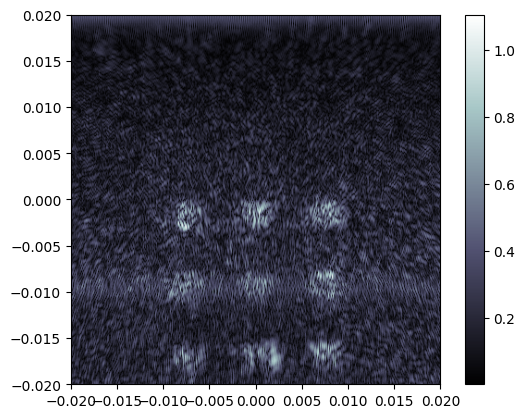

In [13]:
plt.imshow(us_image, origin="lower", cmap="bone", extent=(-lx / 2, lx / 2) * 2)
plt.colorbar()
plt.show()

In [14]:
np.save("output_images/ruct_linear.npy", us_image)